In [ ]:
# import os
# import sys
# os.environ['CUDA_HOME'] = '/u/local/cuda/12.3'
# os.environ['PATH'] = f"/u/local/cuda/12.3/bin:{os.environ['PATH']}"

In [ ]:
# !pip --version
# !conda --version
# !nvcc --version
# !mamba --version

In [ ]:
# !conda env list
# !conda list
# !mamba env list
# !mamba list
# !pip list

In [ ]:
# !conda create -y -n my-conda-env
# !source activate my-conda-env
# !conda create -n rapids-24.10 -c rapidsai-nightly -c conda-forge -c nvidia  \
#     rapids=24.10 python=3.9 'cuda-version>=12.0,<=12.5' -y

In [ ]:
# Install cuDF and dask_cudf from the RAPIDS channel
# !mamba create --prefix ~/.conda/envs/my_rapids_env -c rapidsai-nightly -c conda-forge -c nvidia  \
#     rapids=24.10 python=3.10 'cuda-version>=12.0,<=12.5' -y

In [ ]:
# !pip install methylsuite
# !pip install mepylome
# !pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     cudf-cu12 dask-cudf-cu12 dask-cuda --only-binary=:all:
# !pip install pandas==2.2.1 FuzzyTM numpy pyaging scipy seaborn matplotlib -U
# !pip install numpy pyaging --no-cache-dir -U
# !pip cache purge
# run in terminal: conda clean --all -y

In [34]:
import gc
import psutil
import inspect
import shutil
import json
import cupy as cp
import cudf
import dask_cudf
from dask_cuda import LocalCUDACluster
import dask
from dask.distributed import Client, wait
import pyarrow.parquet as pq
import dask.dataframe as dd
import torch
import pickle
import pandas as pd
import pyaging as pya
import numpy as np
import scipy.stats as stats
import scipy.sparse as sp
from scipy import stats
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from numba import jit, prange
import matplotlib.gridspec as gridspec
from mepylome import Manifest
import statsmodels.api as sm
from statsmodels.formula.api import ols
import mpmath
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from scipy.stats import pearsonr

In [102]:
# !pip freeze > requirements.txt

In [3]:
# clean unused memory
gc.collect()
psutil.virtual_memory()

svmem(total=540801236992, available=532608237568, percent=1.5, used=7101562880, free=232538886144, active=117972115456, inactive=181885808640, buffers=219987968, cached=300940800000, shared=1236992, slab=2506706944)

In [4]:
# Get EPICv2 manifest
manifest_450k = Manifest("450k")
manifest_epic = Manifest("epic")
manifest_epic_v2 = Manifest("epicv2")

probes_df_e2 = manifest_epic_v2.data_frame
probes_df_e = manifest_epic.data_frame
probes_df_450 = manifest_450k.data_frame

# Extract probe IDs (assuming 'IlmnID' is the column with probe names)
epicv2_probes = probes_df_e2['IlmnID'].tolist()
epic_probes = probes_df_e['IlmnID'].tolist()
i450_probes = probes_df_450['IlmnID'].tolist()

print(f"Number of probes in EPICv2: {len(epicv2_probes)}")
print(f"First few probes: {epicv2_probes[:5]}")
print(f"Number of probes in EPIC: {len(epic_probes)}")
print(f"First few probes: {epic_probes[:5]}")
print(f"Number of probes in 450k: {len(i450_probes)}")
print(f"First few probes: {i450_probes[:5]}")

# Load GrimAge2 feature sets
df = pd.read_csv('grimage2_subcomponents.csv', index_col=0)
df_grimage = pd.read_csv('grimage2.csv', index_col=0)

# Extract unique probes from GrimAge2
grimage2_probes = np.unique(df['var'])[2:].tolist()

print(f"Number of unique probes in GrimAge2: {len(grimage2_probes)}")
print(f"First few GrimAge2 probes: {grimage2_probes[:5]}")

Number of probes in EPICv2: 930658
First few probes: ['cg25497136', 'cg03112325', 'cg03112355', 'cg03112358', 'cg03112360']
Number of probes in EPIC: 865918
First few probes: ['cg14817997', 'cg26928153', 'cg16269199', 'cg13869341', 'cg14008030']
Number of probes in 450k: 485577
First few probes: ['cg13869341', 'cg14008030', 'cg12045430', 'cg20826792', 'cg00381604']
Number of unique probes in GrimAge2: 1030
First few GrimAge2 probes: ['cg00036119', 'cg00102512', 'cg00126959', 'cg00161556', 'cg00252095']


In [5]:
# Check if all GrimAge2 probes are in all arrays
missing_probes_epicv2 = [probe for probe in grimage2_probes if probe not in epicv2_probes]
missing_probes_epic = [probe for probe in grimage2_probes if probe not in epic_probes]
missing_probes_i450 = [probe for probe in grimage2_probes if probe not in i450_probes]

if not missing_probes_epicv2:
    print("All GrimAge2 probes are present in the EPICv2 set.")
else:
    print(f"Number of missing GrimAge2 probes in EPICv2: {len(missing_probes_epicv2)}")
    print(f"First few missing GrimAge2 probes in EPICv2: {missing_probes_epicv2[:5]}")
if not missing_probes_epic:
    print("All GrimAge2 probes are present in the EPIC set.")
else:
    print(f"Number of missing GrimAge2 probes in EPIC: {len(missing_probes_epic)}")
    print(f"First few missing GrimAge2 probes in EPIC: {missing_probes_epic[:5]}")
if not missing_probes_i450:
    print("All GrimAge2 probes are present in the i450 set.")
else:
    print(f"Number of missing GrimAge2 probes in 450k: {len(missing_probes_i450)}")
    print(f"First few missing GrimAge2 probes in 450k: {missing_probes_i450[:5]}")

Number of missing GrimAge2 probes in EPICv2: 185
First few missing GrimAge2 probes in EPICv2: ['cg00554421', 'cg00564555', 'cg00684178', 'cg00706683', 'cg00892703']
Number of missing GrimAge2 probes in EPIC: 1
First few missing GrimAge2 probes in EPIC: ['cg24506130']
All GrimAge2 probes are present in the i450 set.


In [6]:
# Load methylation data subset and final
subset_path_parquet = '/u/project/ophoff/cobeaman/Tools/DNAmGrimAgeGitHub/input/mymetharray_subset_2458_r_654_c_08152024_192025.parquet'
final_path_parquet = '/u/scratch/c/cobeaman/mymetharray_final_2458_r_731791_c_08152024_192025.parquet'

methylation_data_subset = pq.read_table(subset_path_parquet)
methylation_data_final = pq.read_table(final_path_parquet)

# Convert the cuDF DataFrame to a pandas DataFrame
methylation_data_subset_pd = methylation_data_subset.to_pandas()
methylation_data_subset_pd.set_index('SampleID', inplace=True)
methylation_data_final_pd = methylation_data_final.to_pandas()
methylation_data_final_pd.set_index('SampleID', inplace=True)

In [109]:
# methylation_data_final_pd.to_pickle('/u/scratch/c/cobeaman/mymetharray_final_2458_r_731791_c_08152024_192025.pkl')
# methylation_data_subset_pd.to_pickle('/u/project/ophoff/cobeaman/Tools/DNAmGrimAgeGitHub/input/mymetharray_subset_2458_r_654_c_08152024_192025.pkl')

In [7]:
# Check data types
# print(methylation_data_subset['Female'].dtype)

# Ensure 'Female' column is binary (0 or 1)
# methylation_data_final['Female'] = (methylation_data_final['Female'] == 1).astype(int)
# methylation_data_subset['Female'] = (methylation_data_subset['Female'] == 1).astype(int)

# Handle any missing data (if necessary)
methylation_data_final_pd.dropna(inplace=True)
methylation_data_subset_pd.dropna(inplace=True)

# Check for missing values
print(methylation_data_final_pd.isnull().sum())
print(methylation_data_subset_pd.isnull().sum())

# Aggregate any duplicated probes
# methylation_data_subset_pd = pya.pp.epicv2_probe_aggregation(methylation_data_subset_pd)
# methylation_data_final_pd = pya.pp.epicv2_probe_aggregation(methylation_data_final_pd)

Age           0
Female        0
Diagnosis     0
Basename      0
cg00381604    0
             ..
cg27649037    0
cg27650212    0
cg27657439    0
cg27658254    0
Gender        0
Length: 731790, dtype: int64
Age           0
Female        0
Diagnosis     0
cg22866430    0
cg18234973    0
             ..
cg06418475    0
cg09438320    0
cg16416603    0
cg00744433    0
cg08706141    0
Length: 653, dtype: int64


In [8]:
@jit(nopython=True, parallel=True)
def parallel_to_numeric(arr):
    result = np.empty(arr.shape, dtype=np.float64)
    for i in prange(arr.shape[0]):
        for j in prange(arr.shape[1]):
            try:
                result[i, j] = float(arr[i, j])
            except ValueError:
                result[i, j] = np.nan
    return result

def prepare_data_for_adata(df, metadata_cols, chunk_size=1000):
    # Separate metadata and data
    metadata = df[metadata_cols]
    data = df.drop(columns=metadata_cols)
    
    # First, try to convert all columns to numeric
    data = data.apply(pd.to_numeric, errors='coerce')
    
    # Process data in chunks
    chunks = []
    for i in range(0, len(data), chunk_size):
        chunk = data.iloc[i:i+chunk_size]
        
        # Convert to GPU array
        chunk_gpu = cp.array(chunk.values, dtype=cp.float64)
        
        # Transfer back to CPU
        chunk_np = cp.asnumpy(chunk_gpu)
        
        chunks.append(pd.DataFrame(chunk_np, columns=chunk.columns, index=chunk.index))
    
    # Combine processed chunks
    data_processed = pd.concat(chunks)
    
    # Combine metadata and converted data
    df_prepared = pd.concat([metadata, data_processed], axis=1)
    
    return df_prepared

# Prepare the data
methylation_data_final_pd_prepared = prepare_data_for_adata(methylation_data_final_pd, ['Female', 'Age', 'Diagnosis'])
methylation_data_subset_pd_prepared = prepare_data_for_adata(methylation_data_subset_pd, ['Female', 'Age', 'Diagnosis'])

In [9]:
for df in [methylation_data_final_pd_prepared, methylation_data_subset_pd_prepared]:
    df['female'] = df['Female']
    df['age'] = df['Age']

In [10]:
# Load GrimAge2 feature sets
df = pd.read_csv('grimage2_subcomponents.csv', index_col=0)
df_grimage = pd.read_csv('grimage2.csv', index_col=0)

# Extract unique probes from GrimAge2
grimage2_probes = np.unique(df['var'])[2:].tolist()

print(f"Number of unique probes in GrimAge2: {len(grimage2_probes)}")
print(f"First few GrimAge2 probes: {grimage2_probes[:5]}")

# identify missing GrimAge2 probes in methylation data
grimage2_missing_features = [probe for probe in grimage2_probes if probe not in methylation_data_final_pd_prepared.columns]

# print("Missing features:", missing_features)
if not grimage2_missing_features:
    print("All GrimAge2 probes are present in the methylation data.")
else:
    print(f"Number of missing GrimAge2 probes in methylation data: {len(grimage2_missing_features)}")
    print(f"First few missing GrimAge2 probes in methylation data: {grimage2_missing_features[:5]}")

Number of unique probes in GrimAge2: 1030
First few GrimAge2 probes: ['cg00036119', 'cg00102512', 'cg00126959', 'cg00161556', 'cg00252095']
Number of missing GrimAge2 probes in methylation data: 380
First few missing GrimAge2 probes in methylation data: ['cg00036119', 'cg00456299', 'cg00480331', 'cg00554421', 'cg00564555']


In [ ]:
# # 1. Data Preparation and Exploratory Analysis
# def prepare_data(df, missing_features):
#     # Separate methylation data from metadata
#     methylation_data = df[[col for col in df.columns if col.startswith('cg')]]
#     metadata = df[['female', 'age', 'Diagnosis']]
    
#     # Add missing columns
#     for col in missing_features:
#         if col not in methylation_data.columns and col.startswith('cg'):
#             methylation_data[col] = np.nan
    
#     return methylation_data, metadata

# def exploratory_analysis(df):
#     missing_percentages = df.isnull().mean() * 100
#     print(f"Average percentage of missing values: {missing_percentages.mean():.2f}%")
#     plt.figure(figsize=(10, 5))
#     sns.histplot(missing_percentages, bins=50)
#     plt.title("Distribution of Missing Values Percentage")
#     plt.xlabel("Percentage of Missing Values")
#     plt.show()

# # 2. Initial Imputation with KNN
# def knn_impute(df, n_neighbors=5):
#     imputer = KNNImputer(n_neighbors=n_neighbors)
#     imputed_data = imputer.fit_transform(df)
#     return pd.DataFrame(imputed_data, columns=df.columns, index=df.index)

# # 3. Advanced Imputation with MICE and Random Forest
# def mice_rf_impute(df, max_iter=10, n_estimators=100, random_state=0):
#     imputer = IterativeImputer(
#         estimator=RandomForestRegressor(n_estimators=n_estimators, random_state=random_state),
#         max_iter=max_iter,
#         random_state=random_state
#     )
#     imputed_data = imputer.fit_transform(df)
#     return pd.DataFrame(imputed_data, columns=df.columns, index=df.index)

# # 4. Deep Learning Imputation
# def create_autoencoder(input_dim, encoding_dim):
#     input_layer = Input(shape=(input_dim,))
#     encoded = Dense(encoding_dim, activation='relu')(input_layer)
#     decoded = Dense(input_dim, activation='sigmoid')(encoded)
#     autoencoder = Model(input_layer, decoded)
#     autoencoder.compile(optimizer='adam', loss='mse')
#     return autoencoder

# def deep_learning_impute(df, epochs=100, batch_size=32):
#     # Normalize data to [0, 1] range (suitable for beta values)
#     normalized_data = df.values
    
#     # Create a mask for missing values
#     missing_mask = np.isnan(normalized_data)
    
#     # Replace NaNs with mean for initial input
#     col_mean = np.nanmean(normalized_data, axis=0)
#     normalized_data[missing_mask] = np.take(col_mean, missing_mask.nonzero()[1])
    
#     # Create and train the autoencoder
#     input_dim = df.shape[1]
#     encoding_dim = min(input_dim // 2, 256)  # Cap encoding dim to prevent overfitting
#     autoencoder = create_autoencoder(input_dim, encoding_dim)
    
#     autoencoder.fit(normalized_data, normalized_data, 
#                     epochs=epochs, 
#                     batch_size=batch_size, 
#                     shuffle=True,
#                     validation_split=0.2,
#                     verbose=0)
    
#     # Use the model to impute missing values
#     imputed_data = autoencoder.predict(normalized_data)
    
#     # Replace only the missing values in the original data
#     normalized_data[missing_mask] = imputed_data[missing_mask]
    
#     return pd.DataFrame(normalized_data, columns=df.columns, index=df.index)

# # 5. Ensemble Method
# def ensemble_impute(df, methods=['knn', 'mice_rf', 'deep_learning']):
#     imputed_dfs = []
    
#     if 'knn' in methods:
#         imputed_dfs.append(knn_impute(df))
#     if 'mice_rf' in methods:
#         imputed_dfs.append(mice_rf_impute(df))
#     if 'deep_learning' in methods:
#         imputed_dfs.append(deep_learning_impute(df))
    
#     # Average the results from different methods
#     ensemble_imputed = pd.concat(imputed_dfs).groupby(level=0).mean()
#     return ensemble_imputed

# # 6. Validation and Sensitivity Analysis
# def validate_imputation(original_df, imputed_df, n_samples=1000):
#     # Select a subset of non-missing values to compare
#     non_missing_mask = ~original_df.isnull().any(axis=1)
#     sample_indices = np.random.choice(non_missing_mask.index[non_missing_mask], size=n_samples, replace=False)
    
#     original_sample = original_df.loc[sample_indices]
#     imputed_sample = imputed_df.loc[sample_indices]
    
#     mse = mean_squared_error(original_sample.values.flatten(), imputed_sample.values.flatten())
#     correlation, _ = pearsonr(original_sample.values.flatten(), imputed_sample.values.flatten())
    
#     print(f"Mean Squared Error: {mse:.4f}")
#     print(f"Pearson Correlation: {correlation:.4f}")
    
#     plt.figure(figsize=(10, 5))
#     plt.scatter(original_sample.values.flatten(), imputed_sample.values.flatten(), alpha=0.1)
#     plt.xlabel("Original Values")
#     plt.ylabel("Imputed Values")
#     plt.title("Original vs Imputed Values")
#     plt.show()

In [ ]:
# # Main workflow
# def imputation_workflow(df, missing_features):
#     methylation_data, metadata = prepare_data(df, missing_features)
    
#     print("Exploratory Analysis:")
#     exploratory_analysis(methylation_data)
    
#     print("\nPerforming KNN Imputation...")
#     knn_imputed = knn_impute(methylation_data)
    
#     print("\nPerforming MICE with Random Forest Imputation...")
#     mice_rf_imputed = mice_rf_impute(methylation_data)
    
#     print("\nPerforming Deep Learning Imputation...")
#     dl_imputed = deep_learning_impute(methylation_data)
    
#     print("\nPerforming Ensemble Imputation...")
#     ensemble_imputed = ensemble_impute(methylation_data)
    
#     print("\nValidation and Sensitivity Analysis:")
#     validate_imputation(methylation_data, ensemble_imputed)
    
#     # Combine imputed data with metadata
#     final_imputed_data = pd.concat([ensemble_imputed, metadata], axis=1)
    
#     return final_imputed_data

In [ ]:
# imputed_methylation_data = imputation_workflow(methylation_data_final_pd_prepared, grimage2_missing_features)

In [11]:
# Convert DataFrames to AnnData objects
adata_final = pya.pp.df_to_adata(methylation_data_final_pd_prepared, metadata_cols=['Female','Age','Diagnosis'], imputer_strategy='knn')
adata_subset = pya.pp.df_to_adata(methylation_data_subset_pd_prepared, metadata_cols=['Female','Age','Diagnosis'], imputer_strategy='knn')

|-----> 🏗️ Starting df_to_adata function
|-----> ⚙️ Create anndata object started
|-----------? Dropping 2 columns with only NAs: ['Basename', 'Gender'], etc.
|-----> ⚠️ Create anndata object finished [12.3791s]
|-----> ⚙️ Add metadata to anndata started
|-----------> Adding provided metadata to adata.obs
|-----> ✅ Add metadata to anndata finished [0.0015s]
|-----> ⚙️ Log data statistics started
|-----------> There are 2442 observations
|-----------> There are 731787 features
|-----------> Total missing values: 0
|-----------> Percentage of missing values: 0.00%
|-----> ✅ Log data statistics finished [1.8800s]
|-----> ⚙️ Impute missing values started
|-----------> No missing values found. No imputation necessary
|-----> ✅ Impute missing values finished [1.5710s]
|-----> 🎉 Done! [24.3432s]
|-----> 🏗️ Starting df_to_adata function
|-----> ⚙️ Create anndata object started
|-----> ✅ Create anndata object finished [0.0057s]
|-----> ⚙️ Add metadata to anndata started
|-----------> Adding pro

In [12]:
# adata_subset.uns
methylation_data_subset_pd_prepared.columns

Index(['Female', 'Age', 'Diagnosis', 'cg22866430', 'cg18234973', 'cg26110733',
       'cg10636246', 'cg10578779', 'cg17591574', 'cg13371627',
       ...
       'cg00126959', 'cg16067628', 'cg23777956', 'cg06418475', 'cg09438320',
       'cg16416603', 'cg00744433', 'cg08706141', 'female', 'age'],
      dtype='object', length=655)

In [13]:
# Predict age using GrimAge2 for both datasets
pya.pred.predict_age(adata_final, ['GrimAge2'])
pya.pred.predict_age(adata_subset, ['GrimAge2'])

|-----> 🏗️ Starting predict_age function
|-----> ⚙️ Set PyTorch device started
|-----------> Using device: cuda
|-----> ✅ Set PyTorch device finished [0.0057s]
|-----> 🕒 Processing clock: grimage2
|-----------> ⚙️ Load clock started
|-----------------> Data found in pyaging_data/grimage2.pt
|-----------> ✅ Load clock finished [0.1091s]
|-----------? ⚠️ Clock 'grimage2' is for research purposes only. Please check the clock's documentation or notes for more information.
|-----------> ⚙️ Check features in adata started
|-----------------? 380 out of 1032 features (36.82%) are missing: ['cg00036119', 'cg00456299', 'cg00480331'], etc.
|-----------------> Using reference feature values for grimage2
|-----------> ⚠️ Check features in adata finished [0.2803s]
|-----------> ⚙️ Predict ages with model started
|-----------------> There is no preprocessing necessary
|-----------------> The postprocessing method is cox_to_years
|-----------------> in progress: 100.0000%
|-----------> ✅ Predict ages

In [14]:
# Inspect the columns in the obs DataFrame
print(adata_subset.obs.columns)
print(adata_final.obs.columns)

Index(['Female', 'Age', 'Diagnosis', 'grimage2'], dtype='object')
Index(['Female', 'Age', 'Diagnosis', 'grimage2'], dtype='object')


In [15]:
# View the first few rows of predictions
# print(adata_final.obs[['GrimAge2']].head())
print(adata_subset.obs.head())
print(adata_final.obs.head())

# Save predictions to CSV files
# adata_final.obs[['GrimAge2']].to_csv('GrimAge2_predictions_final.csv')
adata_subset.obs.to_csv('GrimAge2_predictions_subset.csv')
adata_final.obs.to_csv('GrimAge2_predictions_final.csv')

             Female   Age Diagnosis   grimage2
SampleID                                      
431-BG00001     1.0  51.0  BipolarI  56.853895
431-BG00002     1.0  33.0  BipolarI  44.490519
431-BG00003     0.0  49.0  BipolarI  57.901585
431-BG00004     0.0  41.0  BipolarI  58.853983
431-BG00006     0.0  64.0  BipolarI  67.782062
             Female   Age Diagnosis   grimage2
SampleID                                      
431-BG00001     1.0  51.0  BipolarI  56.853895
431-BG00002     1.0  33.0  BipolarI  44.490519
431-BG00003     0.0  49.0  BipolarI  57.901585
431-BG00004     0.0  41.0  BipolarI  58.853983
431-BG00006     0.0  64.0  BipolarI  67.782062


In [16]:
# Replace inf with NaN and drop rows where either value is NaN
valid_data = adata_subset.obs[['Age', 'grimage2']].replace([np.inf, -np.inf], np.nan).dropna()

# Extract the synchronized age and grimage2 arrays
age_clean = valid_data['Age']
grimage2_clean = valid_data['grimage2']

# Calculate Pearson correlation
pearson_corr, pearson_p_value = stats.pearsonr(age_clean, grimage2_clean)

# Calculate Spearman correlation (robust to non-linearity)
spearman_corr, spearman_p_value = stats.spearmanr(age_clean, grimage2_clean)

# Calculate Kendall correlation (robust to outliers)
kendall_corr, kendall_p_value = stats.kendalltau(age_clean, grimage2_clean)

# Display the correlation results
# Define a threshold for extremely small p-values
threshold = 1e-320

# Display the correlation results with adjusted p-values
print(f"Pearson correlation: {pearson_corr:.3f}, p-value: {'< {:.0e}'.format(threshold) if pearson_p_value < threshold else '{:.3e}'.format(pearson_p_value)}")
print(f"Spearman correlation: {spearman_corr:.3f}, p-value: {'< {:.0e}'.format(threshold) if spearman_p_value < threshold else '{:.3e}'.format(spearman_p_value)}")
print(f"Kendall correlation: {kendall_corr:.3f}, p-value: {'< {:.0e}'.format(threshold) if kendall_p_value < threshold else '{:.3e}'.format(kendall_p_value)}")

Pearson correlation: 0.922, p-value: < 1e-320
Spearman correlation: 0.905, p-value: < 1e-320
Kendall correlation: 0.743, p-value: < 1e-320


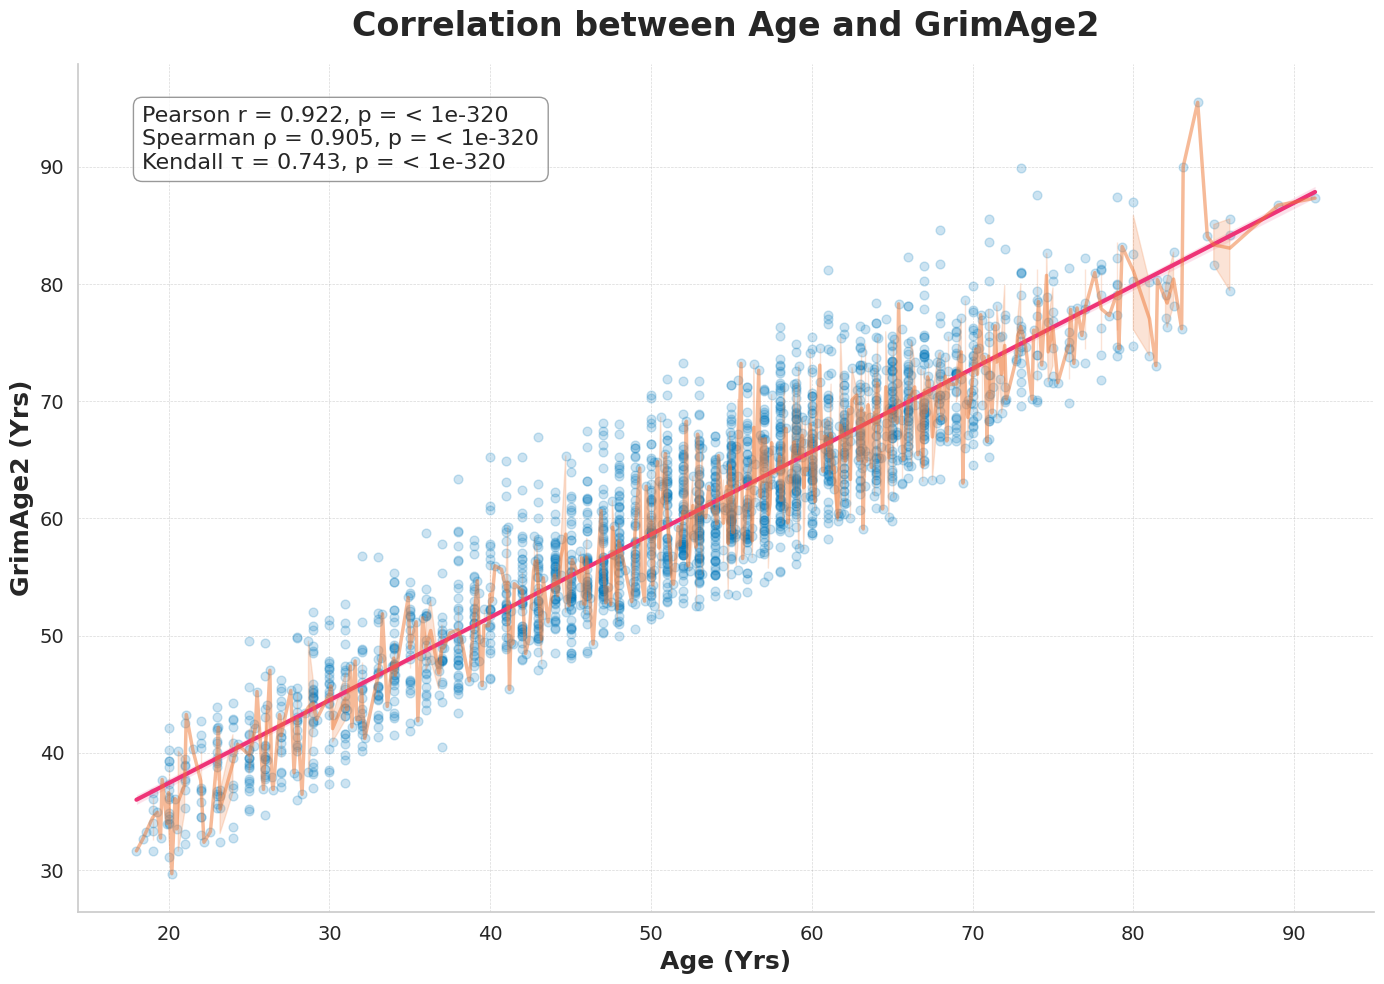

In [18]:
# Set the theme and style for the plot
sns.set_theme(style="whitegrid")

# Create the figure and axis objects
plt.figure(figsize=(14, 10))

# Define a modern color palette with strong contrast and color-blind safety
colors = ['#0077BB', '#EE3377', '#EE7733']  # Vivid Blue, Vibrant Pink, Bright Orange

# Use seaborn's regplot for scatter plot with regression line
sns.regplot(
    x=age_clean,
    y=grimage2_clean,
    ci=95,
    scatter_kws={"s": 40, "alpha": 0.2, "color": colors[0]},  # Vivid Blue points with adjusted opacity
    line_kws={"color": colors[1], "linewidth": 3, "alpha": 1},  # Vibrant Pink regression line, thicker and more opaque
)

# Add a line plot with confidence interval
sns.lineplot(
    x=age_clean,
    y=grimage2_clean,
    errorbar=('ci', 99),
    lw=2.5,  # Increase line width for better visibility
    color=colors[2],  # Bright Orange line plot
    alpha=0.5,  # Increase opacity for confidence intervals
)

# Add titles and labels with enhanced font size
plt.title('Correlation between Age and GrimAge2', fontsize=24, weight='bold', pad=20)
plt.xlabel('Age (Yrs)', fontsize=18, weight='bold')
plt.ylabel('GrimAge2 (Yrs)', fontsize=18, weight='bold')

# Define a threshold for extremely small p-values
threshold = 1e-320

# Create a legend with correlation statistics
legend_text = (
    f"Pearson r = {pearson_corr:.3f}, p = {'< {:.0e}'.format(threshold) if pearson_p_value < threshold else '{:.3e}'.format(pearson_p_value)}\n"
    f"Spearman ρ = {spearman_corr:.3f}, p = {'< {:.0e}'.format(threshold) if spearman_p_value < threshold else '{:.3e}'.format(spearman_p_value)}\n"
    f"Kendall τ = {kendall_corr:.3f}, p = {'< {:.0e}'.format(threshold) if kendall_p_value < threshold else '{:.3e}'.format(kendall_p_value)}"
)
plt.text(0.05, 0.95, legend_text, ha='left', va='top', transform=plt.gca().transAxes, fontsize=16,
         bbox=dict(boxstyle="round,pad=0.4", edgecolor="gray", facecolor="white", alpha=0.8))

# Customize the ticks and labels for better readability
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add grid lines
plt.grid(visible=True, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)

# Remove the top and right spines for a cleaner look
sns.despine()

# Adjust the plot margins
plt.tight_layout()

# Save the plot as an SVG file for high resolution
plt.savefig('Age_vs_GrimAge2_Correlation_Accessible.svg', format='svg', dpi=4000, bbox_inches='tight')

# Show the plot
plt.show()

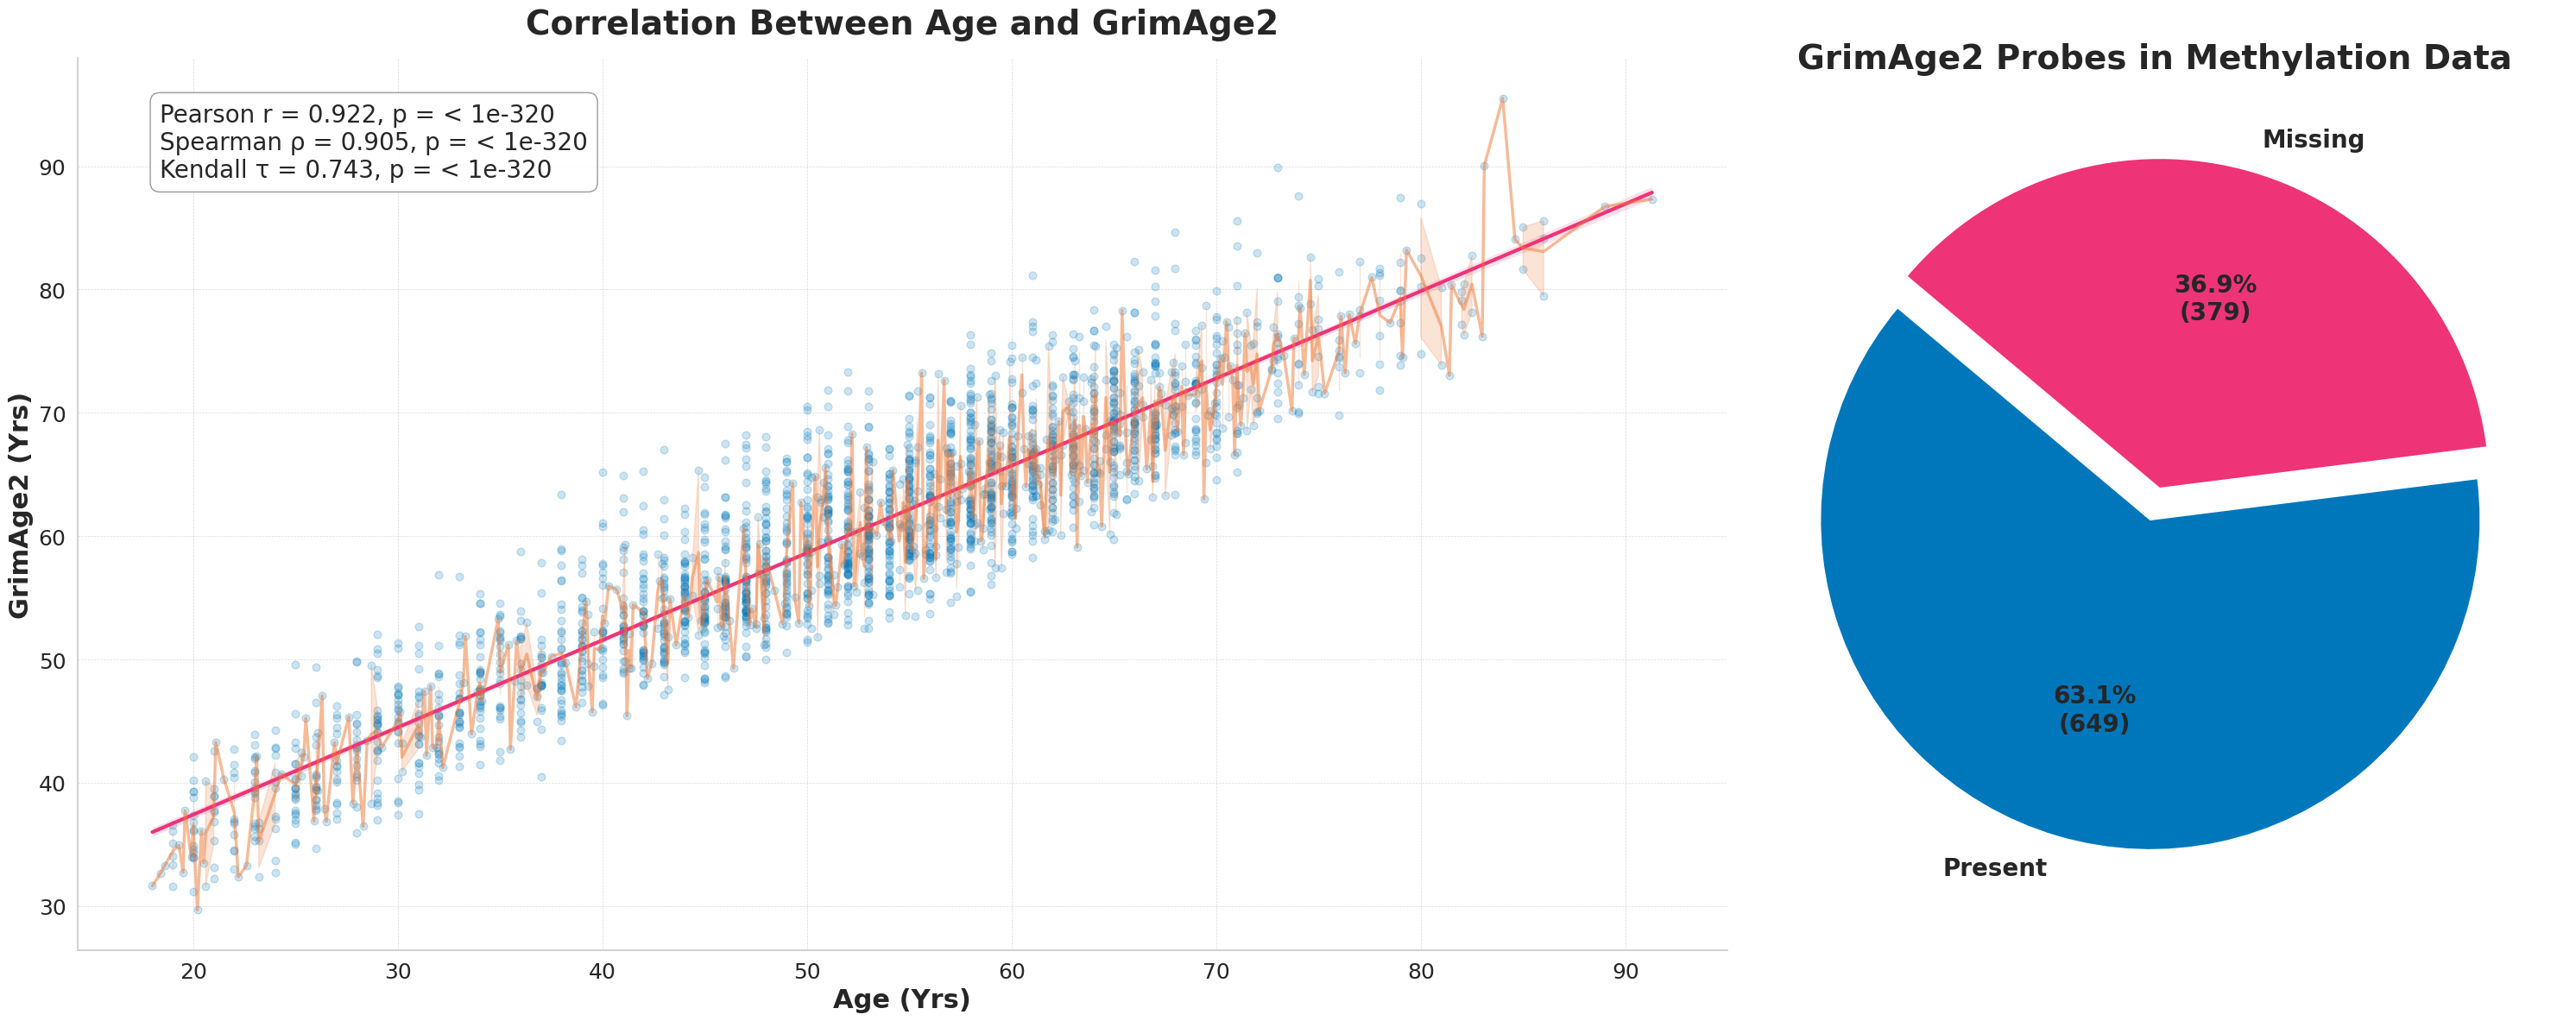

In [22]:
# Calculate the number and percentage of missing probes
total_probes = len(grimage2_probes)
missing_probes_count = len(grimage2_missing_features)
missing_probes_percent = (missing_probes_count / total_probes) * 100

# Set the theme and style for the plot
sns.set_theme(style="whitegrid")

# Define a modern color palette with strong contrast and color-blind safety
colors = ['#0077BB', '#EE3377', '#EE7733']  # Vivid Blue, Vibrant Pink, Bright Orange

# Create a figure with two subplots, giving more space to the main plot
fig, ax = plt.subplots(1, 2, figsize=(30, 12), gridspec_kw={'width_ratios': [2, 1]})

# First subplot: Correlation between Age and GrimAge2
sns.regplot(
    x=age_clean,
    y=grimage2_clean,
    ci=95,
    scatter_kws={"s": 40, "alpha": 0.2, "color": colors[0]},  # Vivid Blue points with adjusted opacity
    line_kws={"color": colors[1], "linewidth": 3, "alpha": 1},  # Vibrant Pink regression line, thicker and more opaque
    ax=ax[0]
)
sns.lineplot(
    x=age_clean,
    y=grimage2_clean,
    errorbar=('ci', 99),
    lw=2.5,  # Increase line width for better visibility
    color=colors[2],  # Bright Orange line plot
    alpha=0.5,  # Increase opacity for confidence intervals
    ax=ax[0]
)
ax[0].set_title('Correlation Between Age and GrimAge2', fontsize=28, weight='bold', pad=20)
ax[0].set_xlabel('Age (Yrs)', fontsize=22, weight='bold')
ax[0].set_ylabel('GrimAge2 (Yrs)', fontsize=22, weight='bold')

# Add legend with correlation statistics
ax[0].text(0.05, 0.95, legend_text, ha='left', va='top', transform=ax[0].transAxes, fontsize=20,
           bbox=dict(boxstyle="round,pad=0.4", edgecolor="gray", facecolor="white", alpha=0.8))

# Customize ticks and grid
ax[0].tick_params(axis='both', labelsize=18)
ax[0].grid(visible=True, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
sns.despine(ax=ax[0])

# Second subplot: Missing GrimAge2 probes (Pie chart)
labels = ['Present', 'Missing']
sizes = [total_probes - missing_probes_count, missing_probes_count]
colors = [colors[0], colors[1]]
explode = (0.05, 0.05)  # Slightly explode the slices for better visibility

ax[1].pie(
    sizes,
    labels=labels,
    autopct=lambda p: f'{p:.1f}%\n({int(p * total_probes / 100):,})',
    colors=colors,
    startangle=140,
    explode=explode,
    textprops={'fontsize': 20, 'weight': 'bold'}
)
ax[1].set_title('GrimAge2 Probes in Methylation Data', fontsize=28, weight='bold', pad=20)

# Adjust the plot margins
plt.tight_layout()

# Save the plot as an SVG file for high resolution
plt.savefig('Age_vs_GrimAge2_Correlation_MissingProbes_Pie_Updated.svg', format='svg', dpi=4000, bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
# import { ScatterChart, Scatter, XAxis, YAxis, ZAxis, Tooltip, Legend, ResponsiveContainer } from 'recharts';

# const generateMockData = (n) => {
#   const data = [];
#   for (let i = 0; i < n; i++) {
#     const age = Math.floor(Math.random() * 60) + 20;
#     const grimAge = age + (Math.random() * 20 - 10);
#     const isBipolar = Math.random() > 0.5;
#     data.push({
#       age: age,
#       grimAge: grimAge,
#       group: isBipolar ? 'Bipolar' : 'Control',
#     });
#   }
#   return data;
# };

# const data = generateMockData(100);

# const AgeCorrelationPlot = () => {
#   return (
#     <ResponsiveContainer width="100%" height={400}>
#       <ScatterChart margin={{ top: 20, right: 20, bottom: 20, left: 20 }}>
#         <XAxis type="number" dataKey="age" name="Chronological Age" unit="years" />
#         <YAxis type="number" dataKey="grimAge" name="Biological Age (GrimAge)" unit="years" />
#         <ZAxis type="category" dataKey="group" name="Group" />
#         <Tooltip cursor={{ strokeDasharray: '3 3' }} />
#         <Legend />
#         <Scatter name="Bipolar" data={data.filter(d => d.group === 'Bipolar')} fill="#8884d8" />
#         <Scatter name="Control" data={data.filter(d => d.group === 'Control')} fill="#82ca9d" />
#       </ScatterChart>
#     </ResponsiveContainer>
#   );
# };

# export default AgeCorrelationPlot;

In [31]:
# Summarize original diagnosis counts
diagnosis_counts = adata_subset.obs['Diagnosis'].value_counts()
print(diagnosis_counts)

# Regroup all Diagnosis entries into Bipolar diagnosis vs Other
df = adata_subset.obs.copy()
df['Diagnosis'] = df['Diagnosis'].apply(lambda x: 'Bipolar' if 'Bipolar' in x else 'Other')
diagnosis_counts_new = df['Diagnosis'].value_counts()
print(diagnosis_counts_new)
print(df)

Diagnosis
Bipolar                     1107
Control                      335
BipolarI                     268
Other                        267
No diagnosis                 185
Bipolar II                    94
Nodiagnosis                   91
Bipolar I                     47
Schizoaffective disorder      21
BipolarII                     14
Pending                       10
Schizophrenia                  3
Name: count, dtype: int64
Diagnosis
Bipolar    1530
Other       912
Name: count, dtype: int64
             Female   Age Diagnosis   grimage2
SampleID                                      
431-BG00001     1.0  51.0   Bipolar  56.853895
431-BG00002     1.0  33.0   Bipolar  44.490519
431-BG00003     0.0  49.0   Bipolar  57.901585
431-BG00004     0.0  41.0   Bipolar  58.853983
431-BG00006     0.0  64.0   Bipolar  67.782062
...             ...   ...       ...        ...
431-BG01563     0.0  50.0   Bipolar  66.372337
431-BG01444     1.0  37.0   Bipolar  50.446918
431-BG01403     1.0  44.0   Bi

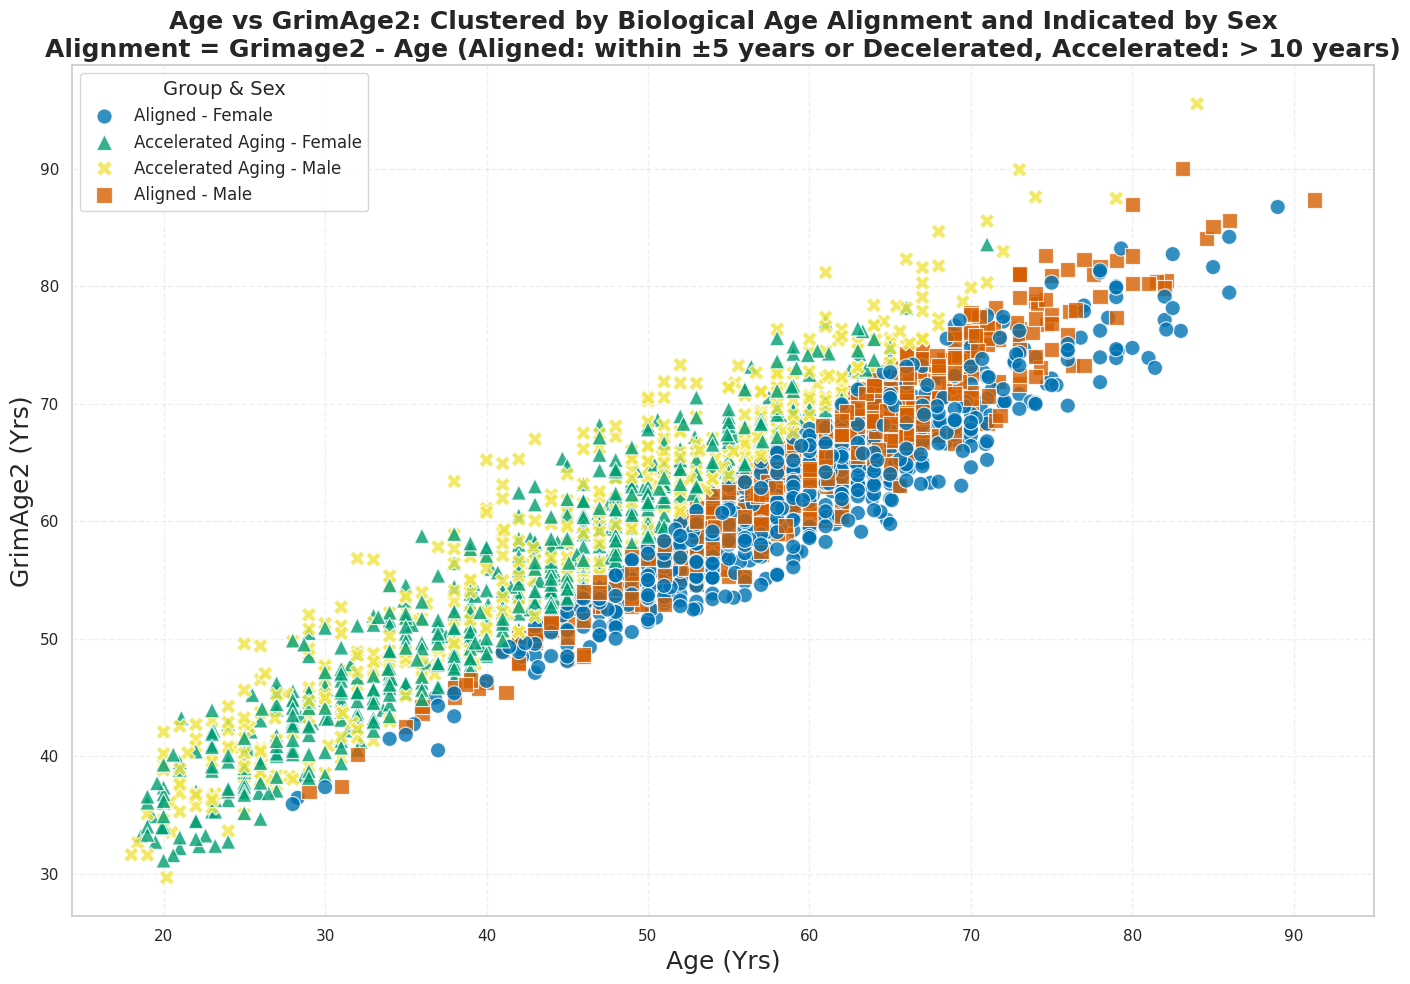

               Group     Sex        Age              grimage2             \
                                   mean        std       mean        std   
0  Accelerated Aging  Female  41.418891  11.322214  54.079104  10.509400   
1  Accelerated Aging    Male  45.002637  13.249995  58.408003  12.125228   
2            Aligned  Female  58.737127   9.400374  61.856411   7.664900   
3            Aligned    Male  60.611858   9.562330  65.024435   8.557561   

  Difference           Count  
        mean       std  size  
0  12.660214  3.106184   667  
1  13.405366  3.766944   531  
2   3.119284  3.436963   738  
3   4.412577  2.690204   506  


In [28]:
# Replace inf with NaN and drop rows where either value is NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=['Age', 'grimage2'], inplace=True)

# Calculate the difference between GrimAge2 and Age
df['Difference'] = df['grimage2'] - df['Age']

# Standardize the difference for clustering
scaler = StandardScaler()
df['Scaled_Difference'] = scaler.fit_transform(df[['Difference']])

# Perform K-means clustering, experimenting with different cluster numbers
n_clusters = 2  # Two clusters: Aligned and Accelerated Aging
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(df[['Scaled_Difference']])

# Map the clusters to meaningful names
df['Group'] = df['Cluster'].replace({0: 'Aligned', 1: 'Accelerated Aging'})

# Replace 'Female' column values with 'Female' and 'Male' labels
df['Sex'] = df['Female'].replace({1.0: 'Female', 0.0: 'Male'})

# Create a new column that combines Group and Sex for coloring
df['Group_Sex'] = df['Group'] + ' - ' + df['Sex']

# Use a colorblind-safe palette with higher contrast
color_palette = {
    'Aligned - Female': '#0072B2',       # Bright blue
    'Aligned - Male': '#D55E00',         # Bright orange
    'Accelerated Aging - Female': '#009E73',  # Bright green
    'Accelerated Aging - Male': '#F0E442'     # Bright yellow
}

# Plot the Groups and indicate sex
plt.figure(figsize=(14, 10))
sns.set_style("whitegrid")
scatter = sns.scatterplot(
    data=df,
    x='Age',
    y='grimage2',
    hue='Group_Sex',
    style='Group_Sex',  # Indicating sex by marker style
    markers={'Aligned - Female': 'o', 'Aligned - Male': 's', 'Accelerated Aging - Female': '^', 'Accelerated Aging - Male': 'X'},
    palette=color_palette,
    s=120,
    alpha=0.8
)

# Define the concept of "Alignment" in the title
alignment_text = "Alignment = Grimage2 - Age (Aligned: within ±5 years or Decelerated, Accelerated: > 10 years)"
plt.title(f'Age vs GrimAge2: Clustered by Biological Age Alignment and Indicated by Sex\n{alignment_text}', fontsize=18, fontweight='bold')

# Customize the plot
plt.xlabel('Age (Yrs)', fontsize=18)
plt.ylabel('GrimAge2 (Yrs)', fontsize=18)
plt.legend(title='Group & Sex', fontsize=12, title_fontsize=14)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()

# Save and show the plot
plt.savefig('Age_vs_GrimAge2_Biological_Age_Alignment_Sex_Clustering_Optimized.svg', format='svg', dpi=4000, bbox_inches='tight')
plt.show()

# Summary of group characteristics
group_summary = df.groupby(['Group', 'Sex']).agg({
    'Age': ['mean', 'std'],
    'grimage2': ['mean', 'std'],
    'Difference': ['mean', 'std'],
    'Group': 'size'
}).rename(columns={'Group': 'Count'}).reset_index()

print(group_summary)

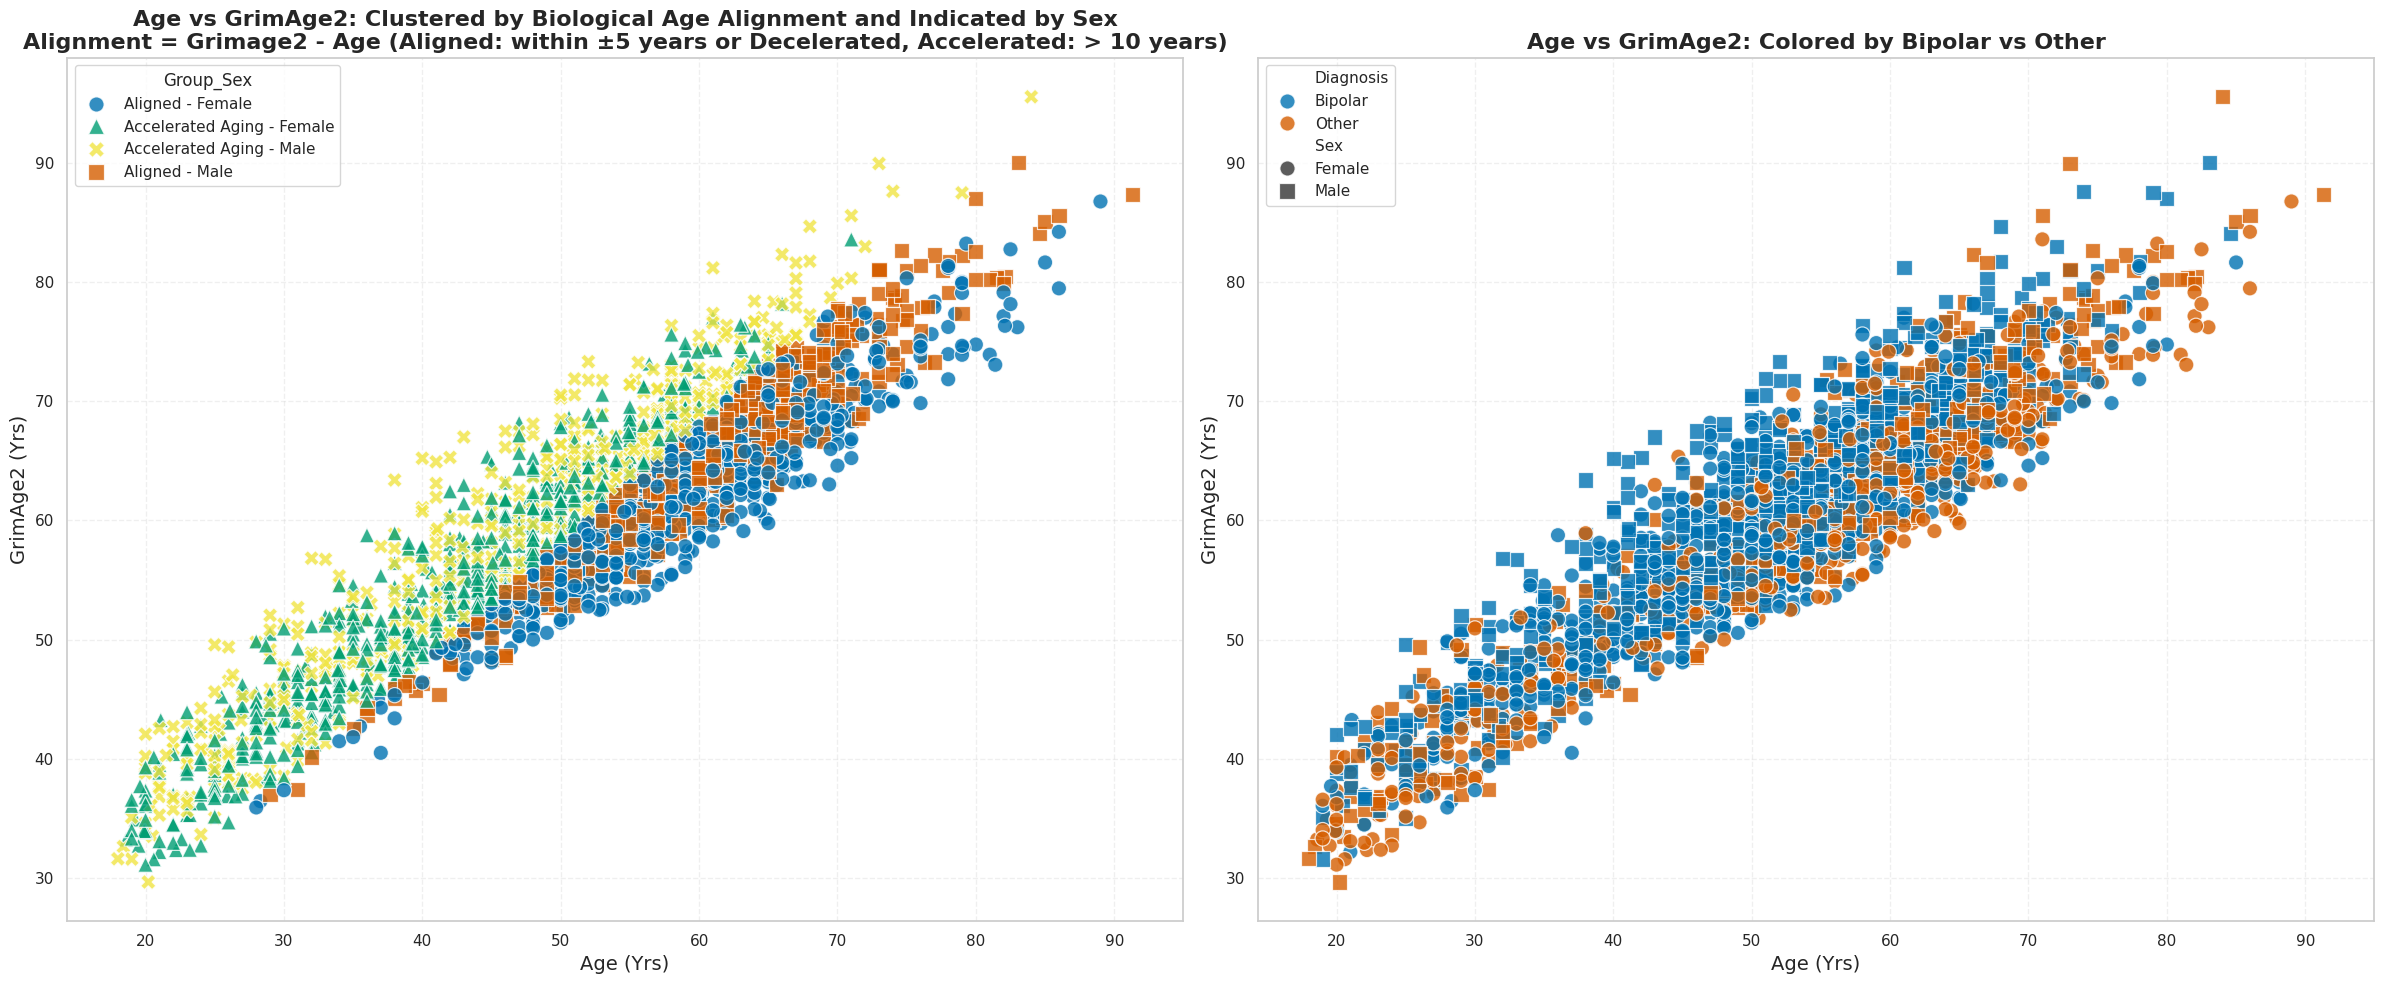

In [33]:
# Assuming df already exists with necessary modifications
# Ensure df contains the Group_Sex column
df['Sex'] = df['Female'].replace({1.0: 'Female', 0.0: 'Male'})

# Calculate the difference between GrimAge2 and Age
df['Difference'] = df['grimage2'] - df['Age']

# Standardize the difference for clustering
scaler = StandardScaler()
df['Scaled_Difference'] = scaler.fit_transform(df[['Difference']])

# Perform K-means clustering
n_clusters = 2  # Two clusters: Aligned and Accelerated Aging
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(df[['Scaled_Difference']])

# Map the clusters to meaningful names
df['Group'] = df['Cluster'].replace({0: 'Aligned', 1: 'Accelerated Aging'})

# Combine Group and Sex for coloring
df['Group_Sex'] = df['Group'] + ' - ' + df['Sex']

# Create a new DataFrame that only keeps the necessary columns for the second plot
df_bipolar_other = df.copy()

# Define the subplots
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# Plot 1: Original plot (Age vs GrimAge2, colored by Group_Sex)
sns.scatterplot(
    data=df,
    x='Age',
    y='grimage2',
    hue='Group_Sex',
    style='Group_Sex',
    markers={'Aligned - Female': 'o', 'Aligned - Male': 's', 'Accelerated Aging - Female': '^', 'Accelerated Aging - Male': 'X'},
    palette=color_palette,
    s=120,
    alpha=0.8,
    ax=axes[0]
)

alignment_text = "Alignment = Grimage2 - Age (Aligned: within ±5 years or Decelerated, Accelerated: > 10 years)"
axes[0].set_title(f'Age vs GrimAge2: Clustered by Biological Age Alignment and Indicated by Sex\n{alignment_text}', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Age (Yrs)', fontsize=14)
axes[0].set_ylabel('GrimAge2 (Yrs)', fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.3)

# Plot 2: New plot (Age vs GrimAge2, colored by Bipolar vs Other)
sns.scatterplot(
    data=df_bipolar_other,
    x='Age',
    y='grimage2',
    hue='Diagnosis',
    style='Sex',
    markers={'Female': 'o', 'Male': 's'},
    palette={'Bipolar': '#0072B2', 'Other': '#D55E00'},  # Use two distinct colors for Bipolar and Other
    s=120,
    alpha=0.8,
    ax=axes[1]
)

axes[1].set_title(f'Age vs GrimAge2: Colored by Bipolar vs Other', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Age (Yrs)', fontsize=14)
axes[1].set_ylabel('GrimAge2 (Yrs)', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.3)

# Adjust layout and show both plots
plt.tight_layout()

# Save the combined plot
plt.savefig('Combined_Age_vs_GrimAge2_Biological_Age_Alignment_Bipolar_vs_Other.svg', format='svg', dpi=4000, bbox_inches='tight')
plt.show()

In [ ]:
model = pya.models.GrimAge2()

In [ ]:
model.metadata.update({
    "clock_name": 'grimage2',
    "data_type": 'methylation',
    "species": 'Homo sapiens',
    "year": 2022,
    "approved_by_author": '⌛',
    "citation": "Lu, Ake T., et al. \"DNA methylation GrimAge version 2.\" Aging (Albany NY) 14.23 (2022): 9484.",
    "doi": "https://doi.org/10.18632/aging.204434",
    "research_only": True,
    "notes": None
})

In [ ]:
urls = [
    "https://pyaging.s3.amazonaws.com/supporting_files/grimage2_subcomponents.csv",
    "https://pyaging.s3.amazonaws.com/supporting_files/grimage2.csv",
    "https://pyaging.s3.amazonaws.com/supporting_files/datMiniAnnotation3_Gold.csv",
]
dir = "."
logger = pya.logger.Logger()

for url in urls:
    pya.utils.download(url, dir, logger, indent_level=1)

In [ ]:
# Load feature sets from CSV files
df = pd.read_csv('grimage2_subcomponents.csv', index_col=0)
df_grimage = pd.read_csv('grimage2.csv', index_col=0)

# Identify features
all_features = np.unique(df['var'])[2:].tolist() + ['Female', 'Age']
model.features = all_features

In [ ]:
# Function to load weights for subcomponents
def load_model_weights(y_pred, model_attr):
    indices = torch.tensor([all_features.index(item) for item in df.loc[df['Y.pred'] == y_pred, 'var'] if item in all_features]).long()
    model_layer = pya.models.LinearModel(input_dim=len(indices))
    model_layer.linear.weight.data = torch.tensor(df.loc[df['Y.pred'] == y_pred, 'beta'][1:].values).unsqueeze(0).float()
    model_layer.linear.bias.data = torch.tensor(df.loc[df['Y.pred'] == y_pred, 'beta'].iloc[0]).float()
    setattr(model, model_attr, model_layer)
    setattr(model, f'features_{model_attr}', indices)

# Apply the function to each subcomponent
components = {
    'DNAmPACKYRS': 'PACKYRS', 
    'DNAmadm': 'ADM', 
    'DNAmB2M': 'B2M',
    'DNAmCystatin_C': 'CystatinC', 
    'DNAmGDF_15': 'GDF15',
    'DNAmleptin': 'Leptin',
    'DNAmpai_1': 'PAI1',
    'DNAmTIMP_1': 'TIMP1',
    'DNAmlog.CRP': 'LogCRP',
    'DNAmlog.A1C': 'A1C'
}

for y_pred, model_attr in components.items():
    load_model_weights(y_pred, model_attr)

# Load base model weights
base_model = pya.models.LinearModel(input_dim=len(df_grimage))
base_model.linear.weight.data = torch.tensor(df_grimage['beta'].tolist()).unsqueeze(0).float()
base_model.linear.bias.data = torch.tensor([0]).float()
model.base_model = base_model

In [ ]:
reference_df = pd.read_csv('datMiniAnnotation3_Gold.csv', index_col=0)
model.reference_values = reference_df.loc[model.features[:-2]]['gold'].tolist() + [1, 65]  # Example: 65-year-old female

In [ ]:
model.preprocess_name = None
model.preprocess_dependencies = None
model.postprocess_name = 'cox_to_years'
model.postprocess_dependencies = None

In [ ]:
pya.utils.print_model_details(model)

In [ ]:
# Define the directory path
weights_dir = "../weights"

# Create the directory if it doesn't exist
os.makedirs(weights_dir, exist_ok=True)

# Save the model
torch.save(model, os.path.join(weights_dir, f"{model.metadata['clock_name']}.pt"))

In [ ]:
# print(methylation_data_subset_pd.columns)
missing_features = [feature for feature in model.features if feature not in methylation_data_subset_pd.columns]
# print("Missing features:", missing_features)
missing_features

In [ ]:
# Extract relevant features
# Adjust the model's features list to include only those present in the data
available_features = [feature for feature in model.features if feature in methylation_data_subset_pd.columns]
input_data_subset = methylation_data_subset_pd[available_features].values

# # Convert to tensor and run the model
# input_tensor_final = torch.tensor(input_data_final, dtype=torch.float32)
# model.eval()
# model.to(float)
# pred = model(input_tensor_final)
# print(pred)

# Convert to tensor and run the model
input_tensor_subset = torch.tensor(input_data_subset, dtype=torch.float32)
model.eval()
model.to(float)
pred = model(input_tensor_subset)
print(pred)

In [ ]:
def remove_folder(path):
    try:
        shutil.rmtree(path)
        print(f"Deleted folder: {path}")
    except Exception as e:
        print(f"Error deleting folder {path}: {e}")

# Get a list of all files and folders in the current directory
all_items = os.listdir('.')        

In [ ]:
for item in os.listdir('.'):
    if os.path.isfile(item) and not item.endswith('.ipynb'):
        os.remove(item)
    elif os.path.isdir(item):
        shutil.rmtree(item)